In [1]:
#instal libraries

#pip install sentence-transformers
#pip install umap-learn
#pip install hdbscan

In [32]:
#import libraries

import re
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
#reads in california constitution

#i need to clean the data more

with open('../DATA/2000.txt', 'r') as f:
    data = f.read()

In [46]:
data

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                           CAST AWAY\n\n\n                              by\n\n                        William Broyles\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n                                               THIRD DRAFT\n\n                                               March 13, 1998\n\n\n\n\nFADE IN:\n\nEXT.  MARFA, TEXAS - 1993 - WIDE - DAY\n\nThe Texas plains, horizon to horizon, nothing but the browns\nand ochres of earth and the blue and violet of the sky.  The\nsheer scope of it sinks in:  the blank slate of nature, the\nabsence of man.  On the screen superimpose:\n\n                    MARFA, TEXAS, 1993.\n\nCREDITS BEGIN.\n\nA plume of dust comes into frame.  The dust is from a TRUCK,\norange and white and violet, with "FedEx" blazoned across the\nside.\n\nThe truck turns into a collection of ramshackle World War II\nera Quonset huts and outbuildings.  Around the outbuildings\nare large sculptures of wood and metal.\n\nEXT.  QUONSET 

In [47]:
#data cleaning

def clean(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, ' ', text)

data = clean(data)
data = data.replace('SEC.', ' ')

In [48]:
#Removes all numbers
data = ''.join([i for i in data if not i.isdigit()])

In [49]:
data = data.split("\n")    

In [50]:
data = [item for item in data if item != '']

In [51]:
data

['                            CAST AWAY',
 '                              by',
 '                        William Broyles',
 '                                               THIRD  DRAFT',
 '                                                March , ',
 'FADE  IN:',
 'EXT.   MARFA, TEXAS -  - WIDE -  DAY',
 'The Texas plains, horizon to horizon, nothing but the browns',
 'and ochres of earth and the blue and violet of the sky.  The',
 'sheer scope of it sinks in:  the blank slate of nature, the',
 'absence of man.  On the screen superimpose:',
 '                     MARFA, TEXAS, .',
 ' CREDITS BEGIN.',
 'A plume of dust comes into frame.  The dust is from a TRUCK,',
 'orange and white and violet, with "FedEx" blazoned across the',
 'side.',
 'The truck turns into a collection of ramshackle World War  ',
 'era Quonset huts and outbuildings.  Around the outbuildings',
 'are large sculptures of wood and metal.',
 'EXT.  QUONSET HUT -  DAY',
 'The door is opened by a WOMAN in her late twenties

In [52]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar = True)

Batches:   0%|          | 0/1316 [00:00<?, ?it/s]

In [53]:
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(embeddings)

In [54]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean', 
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked

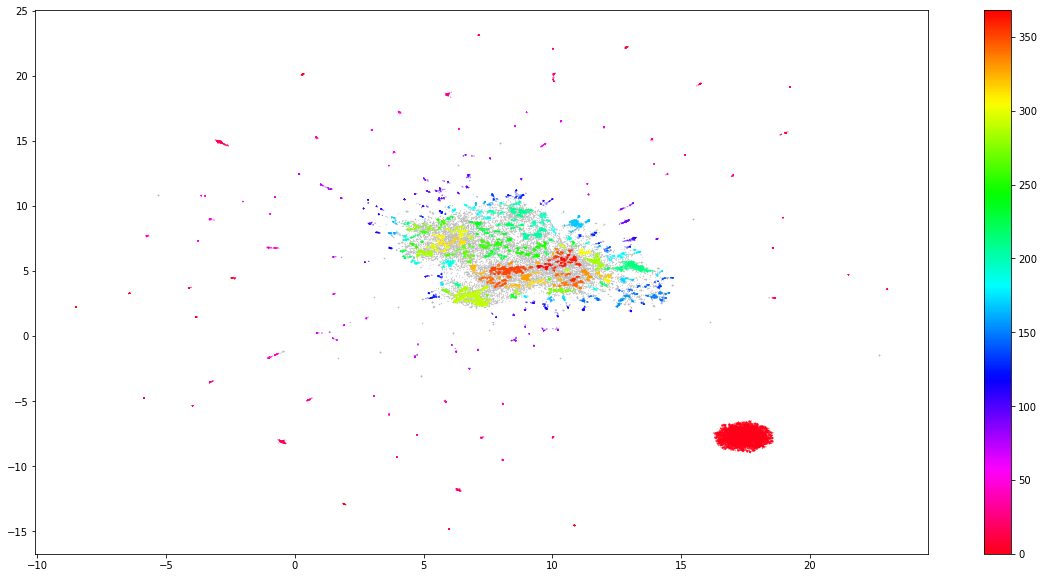

In [55]:
#umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x','y'])
result['labels'] = cluster.labels_

fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [56]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [57]:
docs_per_topic

,Topic,Doc
0,-1,CAST AWAY ...
1,0,FERNANDO ...
2,1,GOODCHUCK ...
3,2,MAXIMUS ...
4,3,Page / ...
...,...,...
365,364,wisp of smoke appears! Chuck saws with even ...
366,365,crisscrossing like a laser show. He ties the l...
367,366,rubs it on his reddened face and across his bu...
368,367,A female Loader slaps a large bar code label ...


In [58]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [59]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [60]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,13666
1,0,7415
291,290,1127
213,212,724
353,352,711
20,19,442
17,16,405
283,282,294
169,168,288
285,284,250


In [16]:
len(top_n_words)

261

In [63]:
index = [0,290,212,352,19,16,282,168]

In [64]:
for i in index:
    print("Topic #", i-1)
    print(top_n_words[i][:7])
    print()

Topic # -1
[('village', 4.1250370019172475), ('fernando', 2.48870552401823), ('mouth', 1.7461019076258049), ('ís', 0.0), ('flaps', 0.0), ('flask', 0.0), ('flashlight', 0.0)]

Topic # 289
[('don', 0.3160872180669464), ('didn', 0.1947263541648902), ('doesn', 0.08867656242357556), ('think', 0.08200670755971358), ('won', 0.07485929390351584), ('want', 0.07284076422980514), ('just', 0.0713289792618449)]

Topic # 211
[('water', 0.17531332220756163), ('raft', 0.1632706024300841), ('fish', 0.15714534794602567), ('ocean', 0.10393893247144759), ('chuck', 0.09705183140187634), ('beach', 0.0878665881339185), ('sea', 0.08228056942719912)]

Topic # 351
[('bad', 0.062369872881525186), ('hurt', 0.061809335208221815), ('know', 0.04893215368730795), ('fear', 0.04829982182098944), ('really', 0.04382978388803004), ('killer', 0.04353272052392909), ('face', 0.042780418503086816)]

Topic # 18
[('claire', 3.9608606687663515), ('ís', 0.0), ('flat', 0.0), ('flask', 0.0), ('flashlight', 0.0), ('flashing', 0.0), 